#Mount and imports

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Nov  3 04:57:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 12.5 MB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
     |████████████████████████████████| 2.9 MB 45.9 MB/s 
     |████████████████████████████████| 126 kB 13.0 MB/s 
     |████████████████████████████████| 1.2 MB 12.6 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 556 (delta 182), reused 244 (delta 91), pack-reused 214
Receiving objects: 100% (556/556), 9.16 MiB | 19.82 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Cloning into 'JUST-Arabic-Propaganda'...
remote: Enumerating objects: 1533, done.
remote: Counting objects: 100% (1533/1533), done.
remote: Compressing objects: 100% (1423/1423), done.
remote: Total 1533 (delta 49), reused 1518 (delta 37), pack-reused 0
Receiving objects: 100% (1533/1533), 3.02 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [5]:
import pandas as pd
import numpy as np
import re

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Pandas Viewing presets

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
pd.reset_option('^display.', silent=True)

#Utility

##Dataset class and functions

In [8]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 
  """
  def __init__(self, text, target, tokenizer):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

In [9]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

def train_fn(data_loader, model, optimizer, device, scheduler):
  """
  Training function. Accepts a torch.dataLoader object, the model to be trained,
  the optimizer, the device to be trained on (ex: Cuda) and finally a scheduler
  for the optimizer.

  The dataLoader is used to iterate over the batches of the training data.
  Performs forward and backprop on the model and saves the weights.
  """
  model.train()

  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
    ids = d["ids"]
    token_type_ids = d["token_type_ids"]
    mask = d["mask"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

def eval_fn(data_loader, model, device):
  """
  Similar to the training function but the model is in evaluation mode (model 
  layers are frozen).

  Performs forward-prop on the model with the validation data.
  Returns the model predictions as well as the data gold labels.
  """
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

##Preprocessing Code

In [10]:
# """
# Old code.
# """

# def MapLabels(df):
#   """
#   Function to preprocess data.
#   Removes unwanted datasamples according to specific labels.
#   Creates a one-hot-encoded version of the labels. 
#   """
#   onehot_col = []
#   df.drop(df.loc[df['label']=='Repetition'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Bandwagon'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Straw_Men'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Whataboutism'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Reductio_ad_hitlerum'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Red_Herring'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Obfuscation,Intentional_Vagueness,Confusion'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Thought-terminating_Cliches'].index, inplace=True)

#   map = {
#       'Slogans':0,
#       'Black-and-White_Fallacy':1,
#       'Loaded_Language':2,
#       'Flag-Waving':3,
#       'Name_Calling':4,
#       'Labeling':5,
#       'Causal_Oversimplification':6,
#       'Exaggeration':7,
#       'Minimisation':8,
#       'Doubt':9,
#       'Appeal_to_Authority':10,
#       'Appeal_to_fear-prejudice':11,
#   }

#   for idx,row in df.iterrows():
#     temp = re.split(',',df.label[idx])
#     label = []
#     onehot = [0] * 12
#     for l in temp:
#       label.append(map[l])
#     for i in label:
#       onehot[i] = 1
#     onehot_col.append(onehot) 
#   df['oneHot'] = onehot_col
#   return df

In [11]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

def train_valid_test_split(dataset, target_col_name):
  """ 
  Function to split a given dataset into train-valid-test.

  dataset: pandas.DataFrame object.
  """
  train_ratio, valid_ratio, test_ratio = config['TRAIN_VALID_TEST_SPLIT']
  train, test = model_selection.train_test_split(dataset, test_size = 1 - train_ratio, shuffle=True, stratify = dataset[target_col_name].values)
  valid, test = model_selection.train_test_split(test, test_size = test_ratio/(test_ratio + valid_ratio), stratify = test[target_col_name].values)

  return train, valid, test

##Trainer Code

In [12]:
def Run(train, valid, text_col_name):
  """
  Main runner code to finetune model. Saves model weights on each epoch if the 
  model score is higher than before.
  """
  target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']
  train = MapLabels(train)
  valid = MapLabels(valid)

  train = train.sample(frac=1).reset_index(drop=True)
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    valid[text_col_name] = valid[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  device = torch.device(config['DEVICE'])
  model = Model()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * config['EPOCHS'])
  optimizer = AdamW(optimizer_parameters, lr=config['LEARNING_RATE'])
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
  )

  best_score = 0
  last_best_epoch = 0
  performance = []
  for epoch in range(config['EPOCHS']):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_samples = metrics.f1_score(targets, outputs,average='samples')
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    f1_macro = metrics.f1_score(targets, outputs,average='macro')
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Samples Score = {f1_samples}")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"f1-Macro Score = {f1_macro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Samples':f1_samples,
                         'F1-Micro':f1_micro,
                         'F1-Macro':f1_macro,
                         'Accuracy':accuracy}
    performance.append(epoch_performance)
    if f1_micro > best_score:
      last_best_epoch = epoch+1
      print("Saving model...")
      torch.save(model.state_dict(), config['PATH']+"model.bin")
      report = report = metrics.classification_report(targets,outputs,target_names=target_names, zero_division=0, digits=4)
      best_score = f1_micro
  
  print(report)
  del model
  return performance, last_best_epoch

##Evaluation Code

In [ ]:
def plot_performance(performance_dict, path):
  f1_micro = []
  accuracy = []

  for epoch_performance in performance_dict['MODEL_EPOCHS']:
    f1_micro.append(epoch_performance['F1-Micro'])
    accuracy.append(epoch_performance['Accuracy'])

  figure(figsize=(15, 5), dpi=100)
  epochs = range(1, len(performance_dict['MODEL_EPOCHS'])+1)

  # plot lines
  plt.scatter(epochs, f1_micro, label = "F1-Micro", color = 'blue')
  plt.scatter(epochs, accuracy, label = "Accuracy", color = 'red')
  plt.plot(epochs, f1_micro, color = 'blue')
  plt.plot(epochs, accuracy, color = 'red')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Score', fontsize=10)
  LAST_BEST_EPOCH = performance_dict['LAST_BEST_EPOCH']
  plt.title(label = "Performance of model over time on validation dataset")
  string = f'footnote: last best epoch is {LAST_BEST_EPOCH} with F1-Micro of {round(f1_micro[LAST_BEST_EPOCH-1], ndigits=4)} and Accuracy of {round(accuracy[LAST_BEST_EPOCH-1], ndigits=4)}'
  plt.figtext(x= 0.1, y = 0.01, s=string, fontsize=10, fontfamily='monospace')
  plt.legend()
  plt.savefig(path,)
  plt.show()

In [13]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

##Tuning Code 

In [19]:
def TuneLearningRate(model_name, train, valid, test, text_col_name, low_lr=1e-5, high_lr=5e-4, epochs=5, patience=3):
  path = f"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/"
  train = MapLabels(train)
  valid = MapLabels(valid)
  test = MapLabels(test)
  print(f"Model: {config['MODEL_ID']}")
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    valid[text_col_name] = valid[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    test[text_col_name] = test[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

  test_data_loader = DataLoader(
      test_dataset, batch_size=1, num_workers=1
  )

  global_score = 0
  best_lr = 0
  device = torch.device(config['DEVICE'])
  performance_for_lrs = []
  lr = 1
  decimal = low_lr
  
  while (lr * decimal) < high_lr:
    poor_performance_counter = 1 # for patience and early stopping.
    current_learning_rate = lr * decimal
    lr+=1
    if lr == 10:
      decimal *= 10
      lr = 1
    
    model = Model()
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * epochs)
    optimizer = AdamW(optimizer_parameters, lr=current_learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    best_score = 0
    print("##################################################")
    print("##################################################\n")
    for epoch in range(epochs):
      train_fn(train_data_loader, model, optimizer, device, scheduler)
      outputs, targets = eval_fn(valid_data_loader, model, device)
      outputs = np.array(outputs) >= 0.5
      f1_micro = metrics.f1_score(targets, outputs,average='micro')
      accuracy = metrics.accuracy_score(targets, outputs)

      print(f"<---------------Epoch {epoch+1}--------------->")
      print(f"f1-Micro Score = {f1_micro}")
      print(f"Accuracy Score = {accuracy}")

      if (f1_micro > best_score) or (epoch == 0):
        best_score = f1_micro
        print("Saving model...")
        torch.save(model.state_dict(), path+f'{model_name}.bin')
        poor_performance_counter = 1
      else:
        if poor_performance_counter == patience:
          break
        else:
          poor_performance_counter += 1
    
    model.load_state_dict(torch.load(path+f'{model_name}.bin'))
    outputs, targets = eval_fn(test_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    accuracy = metrics.accuracy_score(targets, outputs)
    
    print(f"\n<---------------Test Set Performance--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    print(f"Current lr: {current_learning_rate}")
    print(f"Local_Score on training data: {best_score}")
    test_performance = {
        'learning_rate':current_learning_rate,
        'Accuracy':accuracy,
        'f1-micro':f1_micro,
    }
    performance_for_lrs.append(test_performance)
    if f1_micro > global_score:
      print(f"\nChanging global score...")
      print(f"Old Global score: {global_score} with lr={current_learning_rate}")
      global_score = f1_micro
      best_lr = current_learning_rate
      print(f"Global score now: {global_score}, lr={best_lr}")
      print("Saving model...")
      torch.save(model.state_dict(), path+f'{model_name}_final_model.bin')
      best_score = f1_micro
    del model
    print('\n\n')
  
  print(f"\nGlobal_score: {global_score}")
  print(f"Best lr: {best_lr}")

  temp_dict = {
      'Best_LEARNING_RATE':best_lr,
      'Score':global_score,
  }
  performance_for_lrs.append(temp_dict)
  return performance_for_lrs

##Model Class

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config['MODEL_ID'], return_dict=False)
        
        self.bert_drop = nn.Dropout(0.0)
        self.out = nn.Linear(config['HIDDEN_SIZE'], config['NUM_LABELS'])

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

#Config

In [22]:
"""
aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""

config = {
    'MODEL_ID': "UBC-NLP/ARBERT",
    'ArabertPreprocessor': False,
    'HIDDEN_SIZE': 768,
    'DEVICE': "cuda",
    'MAX_LEN': 200,

    'TRAIN_BATCH_SIZE': 32,
    'VALID_BATCH_SIZE': 16,
    'TRAIN_VALID_TEST_SPLIT':(0.8, 0.1, 0.1), # train-valid-test: 0.8-0.1-0.1

    'PATIENCE':3, #for tuning.

    'EPOCHS': 10,
    'LEARNING_RATE': 6e-5,

    'PATH': "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Transformers/",
    'NUM_LABELS': 14,
  }
performance = {}
TOKENIZER = transformers.BertTokenizer.from_pretrained(config['MODEL_ID'])

In [17]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

#Training Code

In [ ]:
model_performance = Run(train, valid, text_col_name='Arabic')
performance['MODEL_EPOCHS'] , performance['LAST_BEST_EPOCH'] = model_performance

with open(config['PATH']+'config.json', 'w') as fp:
    json.dump(config, fp)
with open(config['PATH']+'Epochs.json', 'w') as fp:
    json.dump(performance, fp)

Not using the Arabert Pre-processor


Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Samples Score = 0.3894297635605007
f1-Micro Score = 0.49122807017543857
f1-Macro Score = 0.1367512915552131
Accuracy Score = 0.3894297635605007
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Samples Score = 0.48817802503477054
f1-Micro Score = 0.5558194774346794
f1-Macro Score = 0.2418522079176472
Accuracy Score = 0.48817802503477054
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Samples Score = 0.541029207232267
f1-Micro Score = 0.5805970149253732
f1-Macro Score = 0.29581692540064075
Accuracy Score = 0.541029207232267
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Samples Score = 0.5507649513212796
f1-Micro Score = 0.5819250551065394
f1-Macro Score = 0.3622377015457864
Accuracy Score = 0.5507649513212796
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Samples Score = 0.5799721835883171
f1-Micro Score = 0.599568655643422
f1-Macro Score = 0.37094794950228394
Accuracy Score = 0.5799721835883171
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Samples Score = 0.60778859527121
f1-Micro Score = 0.6247319513938527
f1-Macro Score = 0.441752348444123
Accuracy Score = 0.60778859527121
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Samples Score = 0.6050069541029207
f1-Micro Score = 0.6161473087818696
f1-Macro Score = 0.45125993408426585
Accuracy Score = 0.6050069541029207


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Samples Score = 0.6091794158553546
f1-Micro Score = 0.6221590909090908
f1-Macro Score = 0.4511858390430362
Accuracy Score = 0.6091794158553546


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Samples Score = 0.6091794158553546
f1-Micro Score = 0.6217175301632364
f1-Macro Score = 0.470944052742139
Accuracy Score = 0.6091794158553546


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Samples Score = 0.6050069541029207
f1-Micro Score = 0.6139731827805223
f1-Macro Score = 0.4591136134858492
Accuracy Score = 0.6050069541029207


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Samples Score = 0.6147426981919333
f1-Micro Score = 0.6216596343178623
f1-Macro Score = 0.47460980875659303
Accuracy Score = 0.6147426981919333


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Samples Score = 0.60778859527121
f1-Micro Score = 0.6167960479887085
f1-Macro Score = 0.45837057634231515
Accuracy Score = 0.60778859527121


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Samples Score = 0.6036161335187761
f1-Micro Score = 0.6108374384236452
f1-Macro Score = 0.45996119327403623
Accuracy Score = 0.6036161335187761


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Samples Score = 0.6063977746870653
f1-Micro Score = 0.6119298245614034
f1-Macro Score = 0.46379525568058666
Accuracy Score = 0.6063977746870653


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Samples Score = 0.6133518776077886
f1-Micro Score = 0.6185133239831698
f1-Macro Score = 0.45485561990146045
Accuracy Score = 0.6133518776077886


In [ ]:
path = config['PATH']+"performance.png"
plot_performance(performance, path)

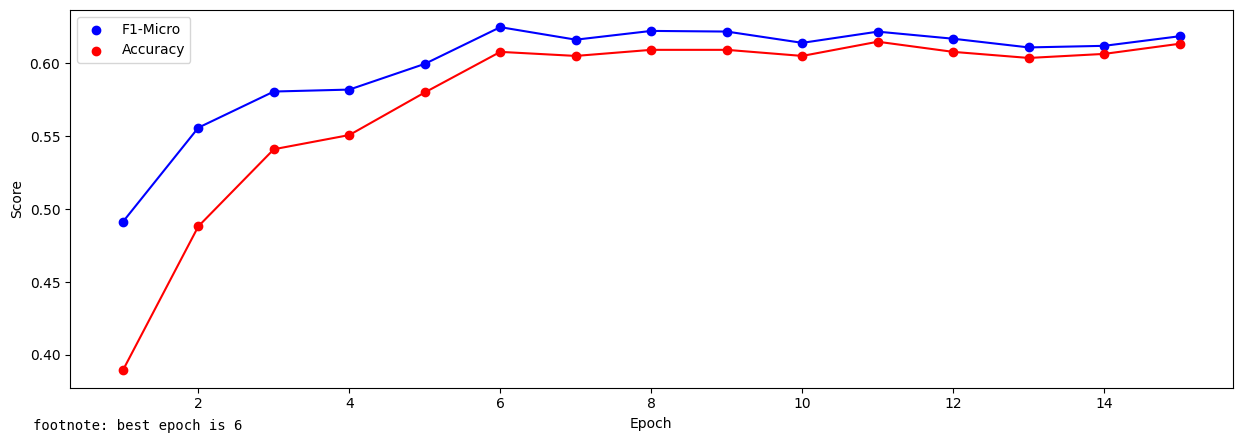

In [ ]:
# importing package
from matplotlib.pyplot import figure

f1_micro = []
accuracy = []

for epoch_performance in performance['MODEL_EPOCHS']:
  f1_micro.append(epoch_performance['F1-Micro'])
  accuracy.append(epoch_performance['Accuracy'])

figure(figsize=(15, 5), dpi=100)
epochs = range(1, len(performance['MODEL_EPOCHS'])+1)

# plot lines
plt.scatter(epochs, f1_micro, label = "F1-Micro", color = 'blue')
plt.scatter(epochs, accuracy, label = "Accuracy", color = 'red')
plt.plot(epochs, f1_micro, color = 'blue')
plt.plot(epochs, accuracy, color = 'red')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Score', fontsize=10)
LAST_BEST_EPOCH = performance['LAST_BEST_EPOCH']
string = f'footnote: best epoch is {LAST_BEST_EPOCH}'
plt.figtext(x= 0.1, y = 0.04, s=string, fontsize=10, fontfamily='monospace')
plt.legend()
plt.savefig("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Transformers/performance.png",)
plt.show()

#Tuning

In [23]:
learning_rate_performance = TuneLearningRate(model_name=config['MODEL_ID'].replace('/','-'),
                                 train=train,
                                 valid=valid,
                                 test=test,
                                 text_col_name='Arabic',
                                 epochs=config['EPOCHS'],
                                 patience=config['PATIENCE'])
tuning_report = {
    'config':config,
    'report':learning_rate_performance,
}
with open(f'/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/tuning_report.json', 'w') as fp:
    json.dump(tuning_report, fp)

Model: UBC-NLP/ARBERT
Not using the Arabert Pre-processor


Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.31385281385281383
Accuracy Score = 0.20166898470097358
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.4730769230769231
Accuracy Score = 0.34214186369958277
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5623931623931625
Accuracy Score = 0.4575799721835883
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5923515052888527
Accuracy Score = 0.5062586926286509
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6119521912350597
Accuracy Score = 0.5340751043115438
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6294573643410852
Accuracy Score = 0.564673157162726
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6285714285714286
Accuracy Score = 0.5660639777468707


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.631578947368421
Accuracy Score = 0.5757997218358831
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.6365030674846626
Accuracy Score = 0.5771905424200278
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.6376811594202899
Accuracy Score = 0.5813630041724618
Saving model...


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6174698795180723
Accuracy Score = 0.5694444444444444
Current lr: 1e-05
Local_Score on training data: 0.6376811594202899

Changing global score...
Old Global score: 0 with lr=1e-05
Global score now: 0.6174698795180723, lr=1e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.47420814479638
Accuracy Score = 0.36439499304589706
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5559322033898305
Accuracy Score = 0.4561891515994437
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6237547892720307
Accuracy Score = 0.5660639777468707
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6255639097744361
Accuracy Score = 0.5785813630041725
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6388059701492537
Accuracy Score = 0.5952712100139083
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.632428466617755
Accuracy Score = 0.5994436717663422


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6353631694790903
Accuracy Score = 0.6022253129346314


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6325785244704164
Accuracy Score = 0.6022253129346314


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.633855331841909
Accuracy Score = 0.5902777777777778
Current lr: 2e-05
Local_Score on training data: 0.6388059701492537

Changing global score...
Old Global score: 0.6174698795180723 with lr=2e-05
Global score now: 0.633855331841909, lr=2e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5068870523415978
Accuracy Score = 0.38386648122392214
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5492393915132106
Accuracy Score = 0.47705146036161333
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6101949025487255
Accuracy Score = 0.5660639777468707
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6275659824046922
Accuracy Score = 0.5952712100139083
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.648134601316752
Accuracy Score = 0.6161335187760779
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6219956300072833
Accuracy Score = 0.5938803894297635


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6342857142857142
Accuracy Score = 0.6175243393602226


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6175839885632594
Accuracy Score = 0.6008344923504868


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6279411764705882
Accuracy Score = 0.5930555555555556
Current lr: 3.0000000000000004e-05
Local_Score on training data: 0.648134601316752



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.44619940769990124
Accuracy Score = 0.3143254520166898
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5741626794258373
Accuracy Score = 0.5006954102920723
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.627245508982036
Accuracy Score = 0.5827538247566064
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6328747284576394
Accuracy Score = 0.60778859527121
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6399416909620991
Accuracy Score = 0.6105702364394993
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6225454545454545
Accuracy Score = 0.5952712100139083


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6336917562724015
Accuracy Score = 0.6147426981919333


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6148359486447932
Accuracy Score = 0.5994436717663422


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6349206349206349
Accuracy Score = 0.6111111111111112
Current lr: 4e-05
Local_Score on training data: 0.6399416909620991

Changing global score...
Old Global score: 0.633855331841909 with lr=4e-05
Global score now: 0.6349206349206349, lr=4e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5224416517055656
Accuracy Score = 0.4047287899860918
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5925925925925927
Accuracy Score = 0.5340751043115438
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6096654275092938
Accuracy Score = 0.5702364394993046
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.611885546588408
Accuracy Score = 0.5799721835883171
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5867052023121387
Accuracy Score = 0.564673157162726


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6196980589503954
Accuracy Score = 0.5994436717663422
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6164874551971327
Accuracy Score = 0.5980528511821975


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5951704545454546
Accuracy Score = 0.5827538247566064


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.6062322946175638
Accuracy Score = 0.5952712100139083


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6030150753768844
Accuracy Score = 0.5833333333333334
Current lr: 5e-05
Local_Score on training data: 0.6196980589503954



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5286343612334802
Accuracy Score = 0.4172461752433936
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5826287471176018
Accuracy Score = 0.5271210013908206
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5986793837123991
Accuracy Score = 0.5674547983310153
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5975164353542732
Accuracy Score = 0.56884561891516


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.610144927536232
Accuracy Score = 0.5855354659248957
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6097560975609756
Accuracy Score = 0.5910987482614742


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6068376068376068
Accuracy Score = 0.5924895688456189


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5949008498583569
Accuracy Score = 0.5841446453407511


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6351056081573198
Accuracy Score = 0.6055555555555555
Current lr: 6.000000000000001e-05
Local_Score on training data: 0.610144927536232

Changing global score...
Old Global score: 0.6349206349206349 with lr=6.000000000000001e-05
Global score now: 0.6351056081573198, lr=6.000000000000001e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5232660228270412
Accuracy Score = 0.4144645340751043
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5822981366459627
Accuracy Score = 0.521557719054242
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5940740740740741
Accuracy Score = 0.5577190542420027
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.602919708029197
Accuracy Score = 0.5744089012517385
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6018718502519798
Accuracy Score = 0.5813630041724618


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6193181818181819
Accuracy Score = 0.6063977746870653
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6109921484653819
Accuracy Score = 0.5952712100139083


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6256192498230716
Accuracy Score = 0.6147426981919333
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.6197583511016348
Accuracy Score = 0.6063977746870653


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.6185421089879688
Accuracy Score = 0.60778859527121


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6386913229018492
Accuracy Score = 0.6236111111111111
Current lr: 7.000000000000001e-05
Local_Score on training data: 0.6256192498230716

Changing global score...
Old Global score: 0.6351056081573198 with lr=7.000000000000001e-05
Global score now: 0.6386913229018492, lr=7.000000000000001e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4886466848319709
Accuracy Score = 0.3741307371349096
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6094100074682599
Accuracy Score = 0.5674547983310153
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5589123867069486
Accuracy Score = 0.5146036161335188


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6010137581462708
Accuracy Score = 0.5771905424200278


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.60882140274765
Accuracy Score = 0.5855354659248957


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.598793363499246
Accuracy Score = 0.5513888888888889
Current lr: 8e-05
Local_Score on training data: 0.6094100074682599



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4822202948829142
Accuracy Score = 0.3866481223922114
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5876993166287016
Accuracy Score = 0.5382475660639777
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5402476780185758
Accuracy Score = 0.4853963838664812


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6076867295141408
Accuracy Score = 0.5827538247566064
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5966690803765388
Accuracy Score = 0.5730180806675939


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5997150997150997
Accuracy Score = 0.5855354659248957


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6041222459132908
Accuracy Score = 0.5910987482614742


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6146059291395518
Accuracy Score = 0.5902777777777778
Current lr: 9e-05
Local_Score on training data: 0.6076867295141408



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5145161290322581
Accuracy Score = 0.44367176634214184
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.525749423520369
Accuracy Score = 0.4756606397774687
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5595147839272177
Accuracy Score = 0.5132127955493742
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6027596223674654
Accuracy Score = 0.5771905424200278
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5988538681948424
Accuracy Score = 0.5813630041724618


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6031294452347084
Accuracy Score = 0.5897079276773296
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5914285714285714
Accuracy Score = 0.5757997218358831


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5828002842928217
Accuracy Score = 0.5702364394993046


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.585400425230333
Accuracy Score = 0.5744089012517385


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5910701630049611
Accuracy Score = 0.5791666666666667
Current lr: 0.0001
Local_Score on training data: 0.6031294452347084



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.0002
Local_Score on training data: 0.0



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.00030000000000000003
Local_Score on training data: 0.0



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.0004
Local_Score on training data: 0.0




Global_score: 0.6386913229018492
Best lr: 7.000000000000001e-05


#Testing Code

In [ ]:
test = MapLabels(test)
if config['ArabertPreprocessor']:
  arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
  test['Arabic'] = test['Arabic'].apply(lambda x:  arabert_prep.preprocess(x))

model = Model()
model.load_state_dict(torch.load(config['PATH']+"model.bin"))
model.eval()
device = torch.device(config['DEVICE'])
model.to(device)

test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

test_data_loader = DataLoader(
    test_dataset, batch_size=1, num_workers=1
)
outputs, targets = eval_fn(test_data_loader, model, device)
outputs = np.array(outputs) >= 0.5
f1 = metrics.f1_score(targets, outputs,average='samples')
f1_micro = metrics.f1_score(targets, outputs,average='micro')
f1_macro = metrics.f1_score(targets, outputs,average='macro')
accuracy = metrics.accuracy_score(targets, outputs)
print(f"<---------------Test Set Performance--------------->")
print(f"f1-Samples Score = {f1}")
print(f"f1-Micro Score = {f1_micro}")
print(f"f1-Macro Score = {f1_macro}")
print(f"Accuracy Score = {accuracy}")

model name:  asafaya/bert-base-arabic 
Arabert_Prep: False 
Accuracy:  0.6152777777777778



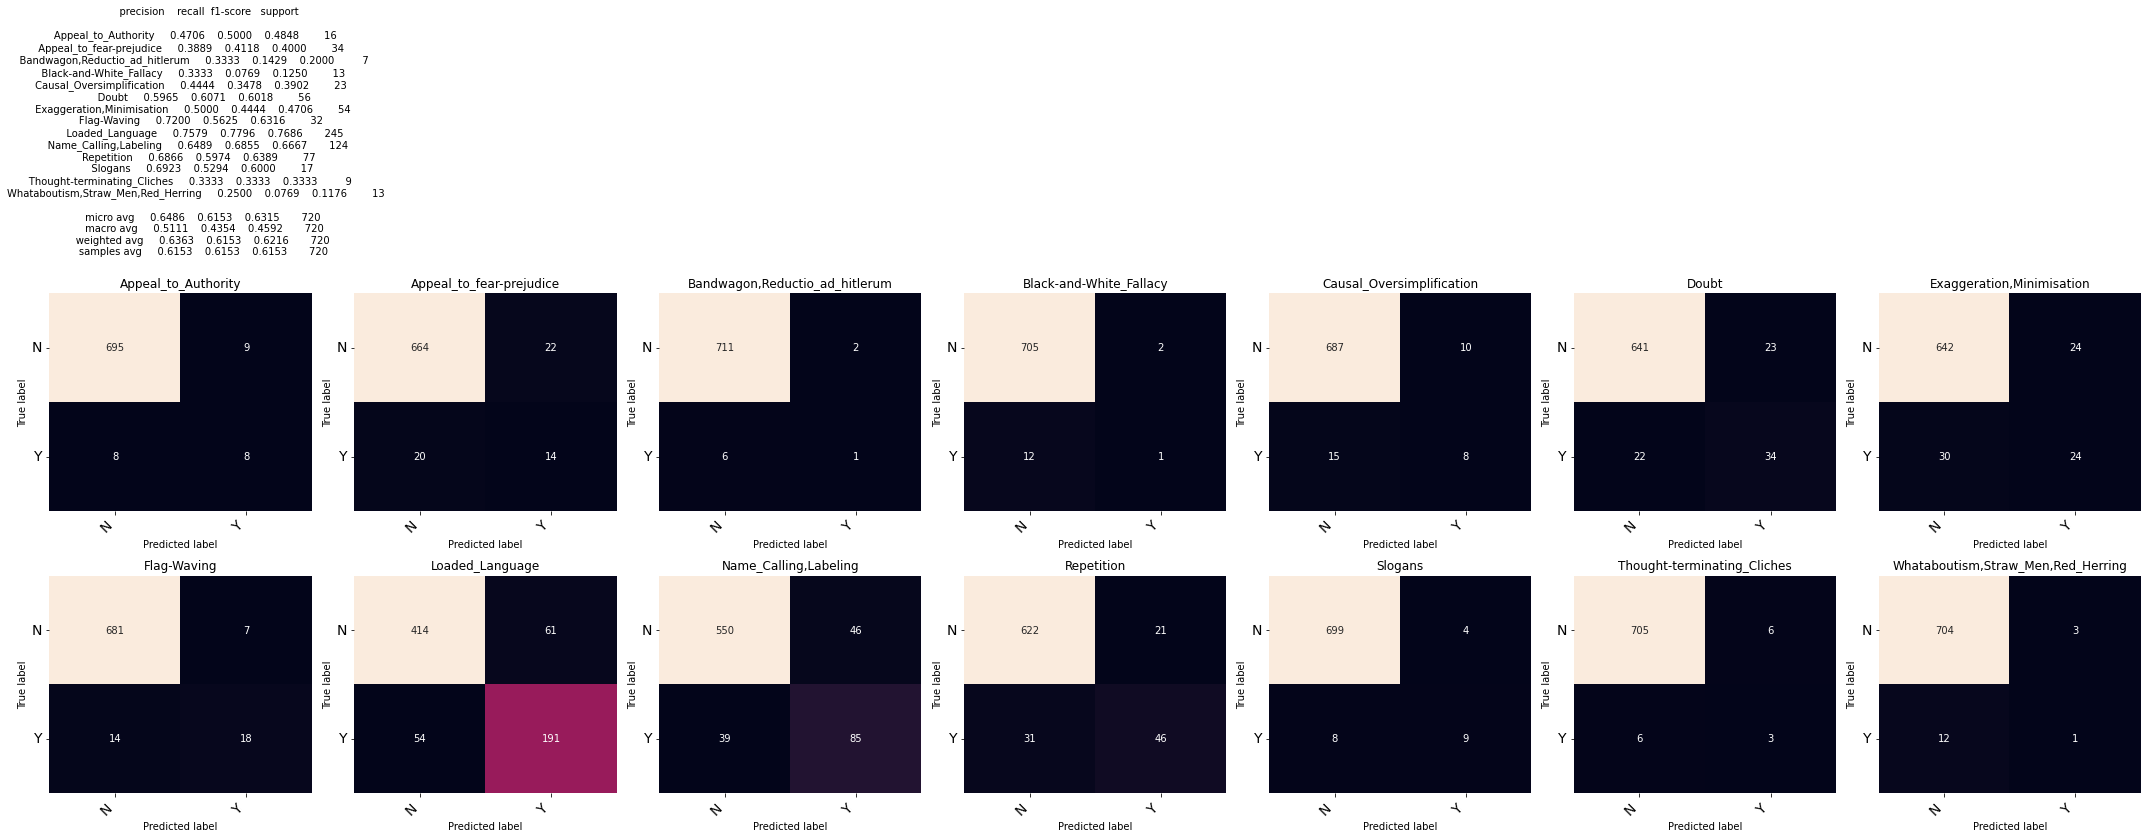

In [ ]:
gold_list = targets
preds_list = outputs

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']


report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)
print("model name: ",config['MODEL_ID'], '\nArabert_Prep:',config['ArabertPreprocessor'],"\nAccuracy: ", accuracy)

print()
print(report)

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig(config['PATH']+"confusion_matrices.png")